In [1]:
#
# Import Libraries
#

import os
import pandas as pd
import pickle
import sys
import networkx as nx
import numpy as np
from scipy.stats import poisson
import itertools

from scipy.stats import pearsonr, spearmanr, kendalltau

from functools import reduce

from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly

import re

palette = plotly.colors.qualitative.Plotly

from pyvis.network import Network

import subprocess

utilsPath = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\utils'
if utilsPath not in sys.path:
    sys.path.append(utilsPath)

In [2]:
#
# Paths & Constants
#

corr_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\02-Correlations\AWHS\corr.pkl'
pval_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\02-Correlations\AWHS\pvals.pkl'

xm_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Metabolomics\AWHS\WorkingFiles\Xm_norm_MS2.tsv'
xq_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Proteomics\AWHS\WorkingFiles\Xq_minus_X_norm.tsv'

m2i_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Metabolomics\AWHS\WorkingFiles\m2info.tsv'
q2i_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Proteomics\AWHS\WorkingFiles\q2info.tsv'

mdata_path = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Metadata\AWHS\WorkingFiles\main_metadata.tsv'

In [3]:
xq = pd.read_csv(xq_path, sep='\t', index_col='Seqn')
xm = pd.read_csv(xm_path, sep='\t', index_col='fid')

q2i = pd.read_csv(q2i_path, sep='\t', index_col='fid')
m2i = pd.read_csv(m2i_path, sep='\t', index_col='fid')

mdata = pd.read_csv(mdata_path, sep='\t')

In [4]:
#
# Read raw data from which the graph will be built
#

with open(corr_path, 'rb') as f:
    corr, corrSL = pickle.load(f)

with open(pval_path, 'rb') as f:
    pv, adpv = pickle.load(f)

Analizar orden y tamaño del grafo usando diferentes tipos de correlaciones y umbrales de FDR

In [5]:
#
# 
#

ctypes = ['rpc', 'psk']

pvrange = np.arange(0,0.2,0.05)

plot = {}

for ctype in ctypes:
    plot[ctype] = {
        'qq': {'nodes':[], 'edges':[]},
        'mm': {'nodes':[], 'edges':[]}, 
    }
    for pv in pvrange:

        qqc = getattr(corr, ctype).qq.dc.copy()
        qqp = adpv[ctype].qq.dc.copy()
        qqg = nx.from_pandas_adjacency(qqc[qqp<=pv].fillna(0))
        plot[ctype]['qq']['nodes'].append((np.array(list(dict(nx.degree(qqg)).values()))>0).sum())
        plot[ctype]['qq']['edges'].append(qqg.size())

        mmc = getattr(corr, ctype).mm.dc.copy()
        mmp = adpv[ctype].mm.dc.copy()
        mmg = nx.from_pandas_adjacency(mmc[mmp<=pv].fillna(0))
        plot[ctype]['mm']['nodes'].append((np.array(list(dict(nx.degree(mmg)).values()))>0).sum())
        plot[ctype]['mm']['edges'].append(mmg.size())


ctypes2 = ['rcca', 'psk', 'cca']

for ctype in ctypes2:
    if ctype not in plot.keys(): plot[ctype]={}
    plot[ctype]['qm'] = {
        'nodes':[], 'edges':[],
    }
    for pv in pvrange:

        qmc = getattr(corr, ctype).qm.dc.copy()
        qmp = adpv[ctype].qm.dc.copy()
        qmg = qmc[qmp<pv].fillna(0)
        qmg = pd.concat([
            pd.DataFrame(columns=qmg.index, index=qmg.index).fillna(0).join(qmg),
            qmg.T.join(pd.DataFrame(columns=qmg.columns, index=qmg.columns).fillna(0))
        ])
        qmg = nx.from_pandas_adjacency(qmg)
        plot[ctype]['qm']['nodes'].append((np.array(list(dict(nx.degree(qmg)).values()))>0).sum())
        plot[ctype]['qm']['edges'].append(qmg.size())

In [17]:
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.express as px

palette = px.colors.qualitative.Plotly

file = 'Plots/FDR_CorrType.html'
if os.path.exists(file):
    os.remove(file)

fig = make_subplots(rows=3, cols=2, subplot_titles=['qq - Nodes', 'qq - Edges','mm - Nodes', 'mm - Edges', 'qm - Nodes', 'qm - Edges'])
plot['psk']['qq']['nodes']

for n,ctype in enumerate(ctypes):
    fig.add_trace(go.Scatter(
        x=pvrange,
        y=plot[ctype]['qq']['nodes'],
        name=ctype, marker_color=palette[n], legendgroup=n
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=pvrange,
        y=plot[ctype]['qq']['edges'],
        name=ctype, marker_color=palette[n], legendgroup=n
    ), row=1, col=2)
    fig.add_trace(go.Scatter(
        x=pvrange,
        y=plot[ctype]['mm']['nodes'],
        name=ctype, marker_color=palette[n], legendgroup=n
    ), row=2, col=1)
    fig.add_trace(go.Scatter(
        x=pvrange,
        y=plot[ctype]['mm']['edges'],
        name=ctype, marker_color=palette[n], legendgroup=n
    ), row=2, col=2)

for n,ctype in enumerate(ctypes2):
    fig.add_trace(go.Scatter(
        x=pvrange,
        y=plot[ctype]['qm']['nodes'],
        name=ctype, marker_color=palette[n], legendgroup=n
    ), row=3, col=1)
    fig.add_trace(go.Scatter(
        x=pvrange,
        y=plot[ctype]['qm']['edges'],
        name=ctype, marker_color=palette[n], legendgroup=n
    ), row=3, col=2)

fig.update_layout(title='Number of nodes and edges per correlation type', width=700, height=500)
fig.show()

with open(file, 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='50%', default_width='80%'))


Construcción de grafo usando Graphical Lasso y rCCA con FDR <0.05

In [6]:
pv = 0.05

qqc = corr.rpc.qq.dc.copy()
qqp = adpv.rpc.qq.dc.copy()
qqg = nx.from_pandas_adjacency(qqc[qqp<=pv].fillna(0))

mmc = corr.rpc.mm.dc.copy()
mmp = adpv.rpc.mm.dc.copy()
mmg = nx.from_pandas_adjacency(mmc[mmp<=pv].fillna(0))

qmc = corr.rcca.qm.dc.copy()
qmp = adpv.rcca.qm.dc.copy()
qmg = qmc[qmp<pv].fillna(0)
qmg = pd.concat([
    pd.DataFrame(columns=qmg.index, index=qmg.index).fillna(0).join(qmg),
    qmg.T.join(pd.DataFrame(columns=qmg.columns, index=qmg.columns).fillna(0))
])
qmg.index, qmg.columns = [i.replace('.', '-') for i in qmg.index], [i.replace('.', '-') for i in qmg.columns]
qmg = nx.from_pandas_adjacency(qmg)

In [7]:
#
# Generate random graphs
#
n = 100

qqA = [nx.gnm_random_graph(qqg.order(), qqg.size(), seed=i) for i in range(n)]
mmA = [nx.gnm_random_graph(mmg.order(), mmg.size(), seed=i) for i in range(n)]

In [8]:
#
# Basic graph characteristics
#

G = qqg
GA = qqA

for G, GA, name in [(qqg, qqA, 'Proteomics'), (mmg, mmA, 'Metabolomics')]:

    print()
    print(name)
    print()

    print(f'Order: {G.order()}')
    print(f'Size: {G.size()}')
    print(f'Density: {round(nx.density(G), 5)}')

    i = [nx.average_clustering(i) for i in GA]
    print(f'Average clustering: {round(nx.average_clustering(G), 5)} (random graph: mean = {round(np.mean(i),5)}, std = {round(np.std(i),5)})')
    print(f'Average degree: {round(np.mean(list(dict(G.degree).values())),5)}')

    i = [len(list(nx.connected_components(i))) for i in GA]
    print(f'Number of connected components: {round(len(list(nx.connected_components(G))), 5)} (random graph: mean = {round(np.mean(i), 5)}, std = {round(np.std(i), 5)})')

    i = [len([i for i in nx.connected_components(g) if len(i)>1]) for g in GA]
    print(f'Number of connected components (order g.t. 1): {round(len([i for i in nx.connected_components(G) if len(i)>1]), 5)} (random graph: mean = {round(np.mean(i),5)}, std = {round(np.std(i),5)})')

fig = make_subplots(rows=1, cols=2, subplot_titles=['Proteomics', 'Metabolomics'])

plot = nx.degree_histogram(qqg)
fig.add_trace(go.Bar(
    x=np.arange(0,len(plot)),
    y=plot,
    offsetgroup=1, marker_color=palette[0]
), row=1,col=1)
fig.add_trace(go.Bar(
    x=np.arange(0,len(plot)),
    y=G.order()*poisson.pmf(np.arange(0, len(plot)),2*G.size()/G.order()),
    offsetgroup=1, marker_color='black', opacity=0.2
), row=1,col=1)


plot = nx.degree_histogram(mmg)
fig.add_trace(go.Bar(
    x=np.arange(0,len(plot)),
    y=plot, 
    offsetgroup=1, marker_color=palette[1]
), row=1,col=2)
fig.add_trace(go.Bar(
    x=np.arange(0,len(plot)),
    y=G.order()*poisson.pmf(np.arange(0, len(plot)),2*G.size()/G.order()),
    offsetgroup=1, marker_color='black', opacity=0.2
), row=1,col=2)

fig.update_layout(bargap=0.2, title='Degree Distribution', showlegend=False)


Proteomics

Order: 381
Size: 5915
Density: 0.08171
Average clustering: 0.22046 (random graph: mean = 0.08175, std = 0.00117)
Average degree: 31.04987
Number of connected components: 2 (random graph: mean = 1.0, std = 0.0)
Number of connected components (order g.t. 1): 1 (random graph: mean = 1.0, std = 0.0)

Metabolomics

Order: 656
Size: 5095
Density: 0.02372
Average clustering: 0.46898 (random graph: mean = 0.02372, std = 0.00108)
Average degree: 15.53354
Number of connected components: 197 (random graph: mean = 1.0, std = 0.0)
Number of connected components (order g.t. 1): 42 (random graph: mean = 1.0, std = 0.0)


In [9]:
#
# Number of connected components with different sizes
#

G = mmg

fig = make_subplots(rows=1, cols=2, subplot_titles=['Proteomics', 'Metabolomics'])#go.Figure()
for n,G in enumerate([qqg, mmg]):
    plot = pd.Series([len(i) for i in nx.connected_components(G)]).value_counts().sort_index()
    fig.add_trace(go.Bar(
        x = [str(i) for i in plot.index],
        y = plot.values,
        width=0.5,
        text=plot.values, textposition='auto', 
    ), row=1, col=n+1)

fig.update_layout(bargap=1)
fig.update_layout(title=f'Number of connected components with different order', showlegend=False)
fig.show()

In [22]:
#
# Number of cliques with diferent orders
#

fig = make_subplots(rows=1, cols=2, subplot_titles=['Proteomics', 'Metabolomics'])#go.Figure()

for n,G in enumerate([qqg, mmg]):
    plot = pd.Series([len(i) for i in nx.find_cliques(G)]).value_counts().sort_index()
    fig.add_trace(go.Bar(
        x = [str(i) for i in plot.index],
        y = plot.values,
        width=0.5,
        text=plot.values, textposition='auto', 
    ), row=1, col=n+1)

    fig.update_layout(bargap=1)
fig.update_layout(title=f'Number of cliques with different order', showlegend=False)
fig.show()

In [10]:
#
# Build complete graph adding omic type to each node
#

g = nx.compose_all([qqg, mmg, qmg])

attr = {}
_ = [attr.update({i:'q'}) for i in q2i.index]
_ = [attr.update({i:'m'}) for i in m2i.index]
nx.set_node_attributes(g, attr, 'group')
attr = {}
_ = [attr.update({i:q2i.loc[i, 'qdesc']}) for i in q2i.index]
_ = [attr.update({i:m2i.loc[i, 'NAME']}) for i in m2i.index]
nx.set_node_attributes(g, attr, 'title')
# attr = {}
# _ = [attr.update({i:'blue'}) for i in q2i.index]
# _ = [attr.update({i:'red'}) for i in m2i.index]
# nx.set_node_attributes(g, attr, 'color')

In [11]:
# Get clustering consensus 

import leidenalg
import igraph as ig
import networkx.algorithms.community as nx_comm

G= mmg
n = 4
thr=10


def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

def get_communities(G, n=5, thr=5):
    comm = [
        list(i.to_networkx().nodes)
        for i in leidenalg.find_partition(
                ig.Graph.from_networkx(G), leidenalg.ModularityVertexPartition, 
                n_iterations=-1, seed=-1
            ).subgraphs()
    ]

    commL = [[i for i in comm if len(i)>thr]]

    for i in range(n):
        commi = [
        list(i.to_networkx().nodes)
        for i in leidenalg.find_partition(
                ig.Graph.from_networkx(G), leidenalg.ModularityVertexPartition, 
                n_iterations=-1, seed=i
            ).subgraphs()
        ] 
        comm = [
        np.intersect1d(j, commi[np.argmax([jaccard(j,k) for k in commi])]) for j in comm
        ]

        #comm = [j for j in comm if nx.is_connected(G.subgraph(j)) and len(j)>thr]
        comm = [list(k) for j in comm for k in nx.connected_components(G.subgraph(j)) if len(k)>thr]
        commL.append(comm)
        if len(comm)==0: return commL
    
    return commL


#qqcom = get_communities(qqg, n=n, thr=10)
#mmcom = get_communities(mmg, n=n, thr=10)

In [12]:
#
# Apply get_communities function to random graphs so as to estimate 
# number of iterations n. 
# We calculate the minimum n at which <1% of random graphs have communities with order >thr
# Probability under randomness of obtain a community

thr = 10 # Minimum size of a community
pvThr = 0.05 # Maximum fraction of random graph with a community greater than thr
n = 100

commLqq = [get_communities(i, n=n, thr=thr) for i in qqA]
commLmm = [get_communities(i, n=n, thr=thr) for i in mmA]

In [13]:
# Get fraction of random graph containing communities after x iterations

commLqqn = [[len(gA[i]) if len(gA)>i else 0 for i in range(n+1)] for gA in commLqq]
commLmmn = [[len(gA[i]) if len(gA)>i else 0 for i in range(n+1)] for gA in commLmm]

commLqqn = (np.array(commLqqn)>0).sum(axis=0)/len(qqA)
commLmmn = (np.array(commLmmn)>0).sum(axis=0)/len(mmA)

pvThr = 0.05
qqThr = np.argwhere(commLqqn < pvThr)[0][0]
mmThr = np.argwhere(commLmmn < pvThr)[0][0]

print(f"Protoemics minimum iteration: {qqThr+1}")
print(f"Metabolomics minimum iteration: {mmThr+1}")

Protoemics minimum iteration: 4
Metabolomics minimum iteration: 5


In [14]:
i = 40

file = 'Plots/ClusterConsensus.html'
if os.path.exists(file):
    os.remove(file)


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(1, i+1),
    y =commLqqn[:i],
    mode='lines+markers',
    name='Proteomics'
))
fig.add_trace(go.Scatter(
    x=np.arange(1, i+1),
    y =commLmmn[:i],
    mode='lines+markers',
    name='Metabolomics'
))
fig.add_hline(y=0.05,line_width=1, line_dash="dot", line_color="black")
fig.update_layout(title='Fraction of Random Networks with communities vs N. Iterations')
fig.update_xaxes(title='Iterations'); fig.update_yaxes(title='Fraction of Random Networks')

fig.show()
with open(file, 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='50%', default_width='80%'))

In [15]:
qqcoms = get_communities(qqg, n=n, thr=thr)
mmcoms = get_communities(mmg, n=n, thr=thr)

In [16]:
i = 40


fig = make_subplots(rows=1, cols=2, subplot_titles=['Number of communities', 'Number of features'])

fig.add_trace(go.Scatter(
    x=np.arange(1,i+1),
    y=[len(i) for i in qqcoms][:i],
    mode='lines+markers',
    name='Proteomics', marker_color=palette[0]
), col=1, row=1)
fig.add_trace(go.Scatter(
    x=np.arange(1,i+1),
    y=[len(i) for i in mmcoms][:i],
    mode='lines+markers',
    name='Metabolomics', marker_color=palette[1]
), col=1, row=1)

fig.add_trace(go.Scatter(
    x=np.arange(1,i+1),
    y=[sum([len(j) for j in i]) for i in qqcoms][:i],
    mode='lines+markers',
    name='Proteomics', marker_color=palette[0]
), col=2, row=1)
fig.add_trace(go.Scatter(
    x=np.arange(1,i+1),
    y=[sum([len(j) for j in i]) for i in mmcoms][:i],
    mode='lines+markers',
    name='Metabolomics', marker_color=palette[1]
), col=2, row=1)

fig.add_vline(x=qqThr+1,line_width=1, line_dash="dot", line_color="black", 
              annotation_text='Prot. Thr.', annotation_position='bottom right')
fig.add_vline(x=mmThr+1,line_width=1, line_dash="dot", line_color="black", 
              annotation_text='Metab. Thr.', annotation_position='top right')

fig.update_xaxes(title='Iterations')

fig.show()
with open(file, 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='50%', default_width='80%'))

In [17]:
qqcom = qqcoms[qqThr]
mmcom = mmcoms[mmThr]

In [22]:
# Number of features per cluster

fig = make_subplots(rows=1, cols=2, subplot_titles=['Proteomics', 'Metabolomics'])
fig.add_trace(go.Bar(
    x=[str(i) for i in range(len(qqcom))],
    y=[len(i) for i in qqcom], width=0.1, showlegend=False
), row=1, col=1)

fig.add_trace(go.Bar(
    x=[str(i) for i in range(len(mmcom))],
    y=[len(i) for i in mmcom], width=0.2, showlegend=False
), row=1, col=2)
fig.update_xaxes(title='Cluster')
fig.update_yaxes(title='N. Features')

fig.show()
with open(file, 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='50%', default_width='80%'))

In [18]:
from sklearn.decomposition import PCA

qqcomPCA = [PCA(n_components=1).fit(xq[com]) for com in qqcom]
mmcomPCA = [PCA(n_components=1).fit(xm[com]) for com in mmcom]

fig = make_subplots(rows=1, cols=2, subplot_titles=['Proteomics', 'Metabolomics'])
fig.add_trace(go.Bar(
    x=[str(i) for i in range(len(qqcom))],
    y=[qqcomPCA[i].explained_variance_ratio_[0] for i in range(len(qqcom))], 
    width=0.1, showlegend=False
), row=1, col=1)

fig.add_trace(go.Bar(
    x=[str(i) for i in range(len(mmcom))],
    y=[mmcomPCA[i].explained_variance_ratio_[0] for i in range(len(mmcom))], 
    width=0.2, showlegend=False
), row=1, col=2)

fig.update_yaxes(range=(0,1))
fig.update_xaxes(title='Cluster')
fig.update_layout(title='Ratio of Explained Variance in the 1st PC')

In [19]:
qqcomE = pd.DataFrame(
    np.array([PCA(n_components=1).fit_transform(xq[com])[:,0] for com in qqcom]).T,
    index=xq.index
)

mmcomE = pd.DataFrame(
    np.array([PCA(n_components=1).fit_transform(xm[com])[:,0] for com in mmcom]).T,
    index=xm.index
)

PESA & AWHS Proteins

In [83]:
import socket
import json

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind(("127.0.0.1", 8080))
s.listen(5)
conn, addr = s.accept()
data = conn.recv(3000)
json_data = data.decode()
xqqcom = json.loads(json_data)

In [183]:
pd.DataFrame([[np.intersect1d(i,j).shape[0]/np.union1d(i,j).shape[0] for j in xqqcom] for i in qqcom])
tmp = {(ni,nj): np.intersect1d(i,j).tolist() for ni,i in enumerate(qqcom) for nj,j in enumerate(xqqcom)}
pd.DataFrame([[np.intersect1d(i,j).shape[0] for j in xqqcom] for i in qqcom])

,0,1,2,3,4
0,5,6,4,1,2
1,5,1,3,3,0
2,5,5,6,10,0
3,1,12,0,4,0
4,8,0,8,1,0
5,1,0,0,0,3


In [184]:
k = pd.DataFrame([], columns=['qdesc', 'Np', 'PESA', 'AWHS'])
for ni, i in enumerate(qqcom):
    for nj, j in enumerate(xqqcom):
        ki = q2i.loc[tmp[(ni,nj)]]
        ki['AWHS'], ki['PESA'] = ni, nj
        k  =pd.concat([k,ki])
        #ki['PESA'] = ni
k.to_excel('Tables/PESA_AWHS.xlsx')

In [43]:
#
# Venn Diagram with enrichment results
#

pesaqq0 = pd.read_excel(
    r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\03-Network\PESA\Clusters\qq_allClusters.xlsx",
    sheet_name='qq_0_string'
    )

pesaqq2 = pd.read_excel(
    r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\03-Network\PESA\Clusters\qq_allClusters.xlsx",
    sheet_name='qq_2_string'
    )

awhsqq0 = pd.read_excel(
    r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\03-Network\AWHS\Clusters\qq_allClusters_AWHS.xlsx",
    sheet_name='qq_0_string'
    )

awhsqq4 = pd.read_excel(
    r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\03-Network\AWHS\Clusters\qq_allClusters_AWHS.xlsx",
    sheet_name='qq_4_string'
    )

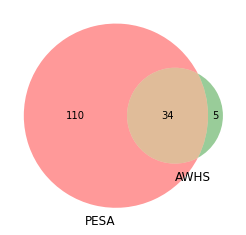

In [59]:
pesaD = np.union1d(pesaqq0.description,pesaqq2.description)
awhsD = np.union1d(awhsqq0.description,awhsqq4.description)

paD = np.intersect1d(pesaD, awhsD)

# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (pesaD.shape[0]-paD.shape[0], awhsD.shape[0]-paD.shape[0], paD.shape[0]), set_labels = ('PESA', 'AWHS'))
plt.show()

In [62]:
np.setdiff1d(pesaD, paD)
# paD

array(['Activation of immune response', 'Acute inflammatory response',
       'Biological regulation', 'Blood coagulation',
       'Blood coagulation, fibrin clot formation',
       'Blood coagulation, intrinsic pathway', 'Cell killing',
       'Cholesterol homeostasis', 'Cholesterol metabolic process',
       'Cholesterol metabolism', 'Cholesterol transport', 'Chylomicron',
       'Chylomicron assembly', 'Chylomicron remodeling', 'Cytolysis',
       'Cytolysis by host of symbiont cells', 'Extracellular region',
       'Extracellular vesicle', 'Fibrinogen complex', 'Fibrinolysis',
       'Glycerolipid metabolic process',
       'High-density lipoprotein particle remodeling',
       'Interaction with symbiont', 'Killing of cells of other organism',
       'Lipid transport', 'Lipoprotein biosynthetic process',
       'Lipoprotein metabolic process', 'Localization',
       'Low-density lipoprotein particle remodeling',
       'Membrane attack complex', 'Membrane-bounded organelle',
      

Module Eigenvector

In [20]:
from PCA_UMAP import PCA_Var

catVars = ['Group', 'smoker', 'diabetes']
conVars = ['Plaque thickness', 'Glucosa', 'hdl', 'coltot', 'FHS10y']

qqCP = pd.concat([
    PCA_Var(xq[com], mdata, conVars, catVars+['Cohort'], n_comp=1)
    for com in qqcom
]).reset_index(drop=True).T

mmCP = pd.concat([
    PCA_Var(xm[com], mdata, conVars, catVars+['Cohort'], n_comp=2).loc[[1]]
    for com in mmcom
]).reset_index(drop=True).T


# Apply FDR B-H correction

from statsmodels.stats.multitest import multipletests

qqCPF = qqCP.iloc[1:, :].copy().T
for i in qqCPF.columns:
    qqCPF[i] = multipletests(qqCPF.loc[:,i], method='fdr_bh')[1]

mmCPF = mmCP.iloc[1:, :].copy().T
for i in mmCPF.columns:
    mmCPF[i] = multipletests(mmCPF.loc[:,i], method='fdr_bh')[1]

In [64]:
mmCPF.T
# qqCPF.T

,0,1,2,3,4,5,6,7,8
Plaque thickness,9.950253e-01,9.950253e-01,9.950253e-01,9.950253e-01,9.950253e-01,9.950253e-01,0.995025,0.995025,0.995025
Glucosa,1.563111e-01,1.964488e-01,2.633993e-01,2.224932e-01,4.219165e-01,8.890974e-02,0.733782,0.421917,0.470188
hdl,1.076156e-08,8.039026e-24,4.750891e-20,1.509549e-04,3.897592e-01,8.146067e-08,0.010866,0.000021,0.050150
coltot,8.316264e-05,9.382843e-05,2.316705e-04,1.063691e-08,1.001757e-11,2.985908e-04,0.121439,0.155629,0.455157
FHS10y,2.448598e-10,7.089764e-15,1.552335e-11,1.886214e-08,1.811202e-05,2.750652e-05,0.021411,0.007082,0.017350
Group,3.656875e-01,2.252228e-01,2.252228e-01,3.040666e-01,4.435619e-01,2.252228e-01,0.443562,0.443562,0.710467
smoker,7.586931e-01,6.203590e-01,7.586931e-01,6.209476e-01,6.442844e-01,6.209476e-01,0.620359,0.758693,0.623611
diabetes,4.100476e-01,4.100476e-01,5.714105e-01,5.714105e-01,8.886504e-01,5.390247e-01,0.888650,0.571410,0.571410
Cohort,9.883761e-01,9.883761e-01,9.883761e-01,9.883761e-01,9.883761e-01,9.883761e-01,0.988376,0.988376,0.988376


In [33]:
# La PC1 de qq1 y qq3 separan entre grupos. Sacar violin plot de la proyección
qqcomE
tmp = dict(list(mdata.set_index('Seqn').loc[qqcomE.index].reset_index('Seqn').groupby('Group')))
tmp2 = pd.melt(qqcomE.reset_index('Seqn'), id_vars='Seqn', value_vars=qqcomE.columns).set_index('Seqn')

fig = go.Figure()
fig.add_trace(go.Violin(x=tmp2.loc[tmp['C'].Seqn].variable,
                        y=tmp2.loc[tmp['C'].Seqn].value,
                        legendgroup='C', scalegroup='C', name='C',
                        side='negative',
                        line_color=palette[0])
             )
fig.add_trace(go.Violin(x=tmp2.loc[tmp['D'].Seqn].variable,
                        y=tmp2.loc[tmp['D'].Seqn].value,
                        legendgroup='D', scalegroup='D', name='D',
                        side='positive',
                        line_color=palette[1])
             )

fig.update_traces(box_visible=False, meanline_visible=True)
fig.update_layout(violinmode='overlay', title='PC1 Projection Distribution per Group')
fig.update_yaxes(title='PC1', range=(-12,12))
fig.update_xaxes(title='Protein Cluster')
fig.show()

In [141]:
from scipy import stats

fig = make_subplots(rows=3, cols=3, vertical_spacing=0.07, subplot_titles=[f'Cluster {i}' for i in range(9)])

y = mdata.set_index('Seqn').FHS10y[mmcomE.index].to_numpy()

i = 0

for i in range(mmcomE.shape[1]):
    x = mmcomE[i].to_numpy()
    b1, b0, r, pvalue, std_err = stats.linregress(x,y)

    fig.add_trace(go.Scatter(
        x=x, y=y, mode='markers', marker_size=2.5,
        marker_color=palette[0],
        showlegend=False
    ),row=1+i//3, col=1+i%3)
    fig.add_trace(go.Scatter(
        x=[x.min(), x.max()],
        y=[x.min()*b1+b0, x.max()*b1+b0], mode='lines', 
        line_width=0.5, line_color='black', showlegend=False
    ),row=1+i//3, col=1+i%3)

    if i%3==0: fig.update_yaxes(title='FHS10y',row=1+i//3, col=1+i%3)
    if i//3==2: fig.update_xaxes(title='PC1',row=1+i//3, col=1+i%3)

fig.update_layout(height=1000, width=1000, title='AWHS')
fig.show()

Pertenencia de cada nodo a su cluster

In [21]:
q2iC = q2i.join(
    pd.DataFrame(
        {q: dict(zip(['ComCorr', 'ComPval', 'Com'], [*pearsonr(qqcomE[n], xq[q]), n])) 
        for n,com in enumerate(qqcom) for q in com}
        ).T,
    how='left'
)

m2iC = m2i.join(
    pd.DataFrame(
        {m: dict(zip(['ComCorr', 'ComPval', 'Com'], [*pearsonr(mmcomE[n], xm[m]), n])) 
        for n,com in enumerate(mmcom) for m in com}
        ).T,
    how='left'
)#.loc[:, ['TP_ID', 'ComCorr', 'ComPval', 'Com']]

In [ ]:
# Write feature info tables separated by cluster

_ = [
    i[1].to_csv(f'Clusters/qq_{int(i[0])}.tsv', sep='\t')
    for i in q2iC[~q2iC['Com'].isna()].groupby('Com')
]

_ = [
    i[1].to_csv(f'Clusters/mm_{int(i[0])}.tsv', sep='\t')
    for i in m2iC[~m2iC['Com'].isna()].groupby('Com')
]

In [37]:
# Write feature info tables separated by cluster

with pd.ExcelWriter(f'Clusters/qq_allClusters.xlsx') as writer:
    _ = [
        i[1].to_excel(writer, sheet_name=f'qq_{int(i[0])}')
        for i in q2iC[~q2iC['Com'].isna()].groupby('Com')
    ]

with pd.ExcelWriter(f'Clusters/mm_allClusters.xlsx') as writer:
    _ = [
        i[1].to_excel(writer, sheet_name=f'mm_{int(i[0])}')
        for i in m2iC[~m2iC['Com'].isna()].groupby('Com')
    ]

Meta-Network WGCNA

In [22]:
# Calcular meta-network mediante correlaciones entre autovectores de los clusteres

import itertools


metaqq = [
    ([i0, i1], [*pearsonr(qqcomE[i0], qqcomE[i1])])
    for i0, i1 in itertools.combinations(qqcomE.columns, 2)
]

metamm = [
    ([i0, i1], [*pearsonr(mmcomE[i0], mmcomE[i1])])
    for i0, i1 in itertools.combinations(mmcomE.columns, 2)
]

cidx = np.intersect1d(qqcomE.index, mmcomE.index)

metaqm = [
    ([i0, i1], [*pearsonr(qqcomE.loc[cidx, i0], mmcomE.loc[cidx, i1])])
    for i0, i1 in itertools.product(qqcomE.columns, mmcomE.columns)
]

In [23]:
metaqm = [[i[0], [*i[1],j]] 
 for i,j in zip(metaqm, multipletests(list(zip(*list(zip(*metaqm))[1]))[1], method='bonferroni')[1])]

In [165]:
pvThr = 0.1
metag = nx.Graph()

_ = [metag.add_node(f'q{i}', group='q', sizee=1-np.log(qqCP.loc['Group',i])) for i in qqcomE.columns]
_ = [metag.add_node(f'm{i}', group='m', sizee=1-np.log(mmCP.loc['Group',i])) for i in mmcomE.columns]
_ = [
    metag.add_edge(f'{xx[0]}{nodes[0]}', f'{xx[1]}{nodes[1]}', r=vals[0], p=vals[1], omic=xx)
    for metaxx, xx in [(metaqq, 'qq'), (metamm, 'mm'), (metaqm, 'qm')][2:]
    for nodes, vals in metaxx if vals[2]<pvThr
]

nt = Network(height='500px', width='100%', select_menu=True, filter_menu=True)
nt.force_atlas_2based()
nt.from_nx(metag)
_ = [i.update({'color': palette[1]}) if i['group']=='m' else i.update({'color': palette[0]}) for i in nt.nodes]
_ = [i.update({'color': 'grey'}) if i['r']>0 else i.update({'color': 'grey'}) for i in nt.edges]
_ = [i.update({'width': -np.log(i['p'])}) for i in nt.edges]
nt.show_buttons(filter_='physics')
nt.show('NT_MetaNetwork_WGCNA.html', notebook=False)

NT_MetaNetwork_WGCNA.html


In [166]:
res = []

pd.DataFrame(
    [(f'q{i[0]}',f'm{i[1]}',j[0]) for i,j in metaqm if j[2]<pvThr],
    columns=['var1', 'var2', 'value']
).to_csv('ChordDiagram/meta-network_WGCNA.tsv', sep='\t', index=False)


#res.to_csv('ChordDiagram/meta-network_WGCNA.tsv', sep='\t', index=False)
#res

Conexiones entre qq y mm mediante Binomial, Poisson y Hypergeom

In [24]:
#
# Binomial
#
from scipy.stats import binom, poisson, hypergeom



tmp = [
    [(i,j), (len(qqcom[i]), len(mmcom[j]))] 
    for i,j in itertools.product(range(len(qqcom)), range(len(mmcom)))
    ]

binRes = []
for iqm, vqm in tmp:

    # The probability estimation for edge existence is the ratio of existing edges
    p = qmg.size()/(xq.shape[1]*xm.shape[1])

    # The number of tests is the total number of possible edges between both clusters
    n = vqm[0]*vqm[1]

    # The x value is the number of existing edges between clusters
    x = qmg.subgraph(
        qqcom[iqm[0]] + mmcom[iqm[1]]
    ).size()

    binRes.append(
        [
        iqm, x, n, p, 
        1-binom.cdf(x-1, n, p), 
        1-poisson.cdf(x-1, n*p),
        1-hypergeom.cdf(x-1, xq.shape[1]*xm.shape[1], n, qmg.size())
        ]
    )

binRes = pd.DataFrame(binRes,
             columns=['iqm', 'x', 'n', 'p', 'Bin', 'Poi', 'Hyp']) 

for i in ['Bin', 'Poi', 'Hyp']:
    binRes[i+'_adj'] = multipletests(binRes['Bin'], method='bonferroni')[1]

In [169]:
res = []

tmp = qmc[qmp<0.05].fillna(0)
tmp.index = [i.replace('.', '-') for i in tmp.index]

for pair in binRes[binRes.Hyp_adj<0.01].iqm.tolist():
    # pair = binRes[binRes.Hyp_adj<0.05].iqm.tolist()[0]

    r = [tmp.loc[q, m] for q,m in list(itertools.product(qqcom[pair[0]], mmcom[pair[1]]))]
    r = np.median([abs(i) for i in r if i!=0])
    res.append([*pair, r])

    # Positive and negative
    # r = [(i, i>0) for i in r if i!=0]
    # r.sort(key=lambda x:x[1])
    # r = [np.median(list(zip(*list(j)))[0]) for i,j in itertools.groupby(r, lambda x:x[1])]
    # res.append([*pair, r[0]]); res.append([*pair, r[1]])

res = pd.DataFrame(
    [[f"q{i[0]}", f"m{i[1]}", i[2]] for i in res],
    columns=['var1', 'var2', 'value']
)

res.to_csv('ChordDiagram/meta-network.tsv', sep='\t', index=False)
res


,var1,var2,value
0,q0,m0,0.129771
1,q0,m1,0.110090
2,q0,m3,0.097165
3,q0,m7,0.122224
4,q2,m0,0.166560
5,q2,m1,0.119225
6,q2,m3,0.135387
7,q2,m7,0.129668
8,q2,m8,0.090760
9,q3,m0,0.108072


In [ ]:
pv = 0.01
metag = nx.Graph()
_ = [metag.add_node(f'q{i}', group='q') for i in range(len(qqcom))]
_ = [metag.add_node(f'm{i}', group='m') for i in range(len(mmcom))]
_ = [metag.add_edge(f'q{i}',f'm{j}') for i,j in binRes.iqm[binRes['Hyp_adj'] < pv]]

In [ ]:
nt = Network(height='500px', width='100%', select_menu=True, filter_menu=True)
nt.force_atlas_2based()
nt.from_nx(metag)
_ = [i.update({'color': palette[1]}) if i['group']=='m' else i.update({'color': palette[0]}) for i in nt.nodes]
_ = [i.update({'color': 'grey'}) for i in nt.edges]
#_ = [i.update({'width': -np.log(i['p'])}) for i in nt.edges]
nt.show_buttons(filter_='physics')
nt.show('NT_MetaNetwork_Hyper.html', notebook=False)

NT_MetaNetwork_Hyper.html


Calcular proteinas más conectadas con metabolitos

In [25]:
qSig = pd.DataFrame([
    (q,x, 1-hypergeom.cdf(x-1, xq.shape[1]*xm.shape[1], xm.shape[1], qmg.size())) 
    for q,x in pd.Series([i[0] for i in qmg.edges.data()]).value_counts().to_dict().items()
], columns=['q', 'x', 'pv']).set_index('q')

qSig['pv_adj'] = multipletests(qSig['pv'], method='bonferroni')[1]

In [26]:
qSig = qSig.join(q2i)

In [175]:
qSig_pesa = pd.read_csv(r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Analysis\03-Network\PESA\qSig.tsv", sep='\t', index_col='q')

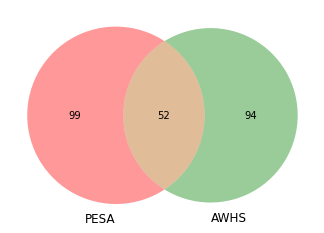

In [216]:
awhsD = qSig.index[np.logical_and(qSig.pv_adj<0.05, qSig.Np>1)]
pesaD = qSig_pesa.index[np.logical_and(qSig_pesa.pv_adj<0.05, qSig_pesa.Np>1)]

paD = np.intersect1d(pesaD, awhsD)

venn2(subsets = (pesaD.shape[0]-paD.shape[0], awhsD.shape[0]-paD.shape[0], paD.shape[0]), set_labels = ('PESA', 'AWHS'))
plt.show()

In [221]:
tmp = qSig.loc[paD]

Metabolitos más conectados con proteínas

In [28]:
mSig = pd.DataFrame([
    (m,x, 1-hypergeom.cdf(x-1, xq.shape[1]*xm.shape[1], xq.shape[1], qmg.size())) 
    for m,x in pd.Series([i[1] for i in qmg.edges.data()]).value_counts().to_dict().items()
], columns=['m', 'x', 'pv']).set_index('m')

mSig['pv_adj'] = multipletests(mSig['pv'], method='bonferroni')[1]

In [37]:
mSig
tmp = mSig.join(m2i).loc[:, ['x','pv', 'pv_adj', 'NAME']]

Explorar proteínas más asociadas a metabolitos de interés

In [ ]:
metabolite = 'C18N71'

tmp2 = pd.DataFrame(
    [(i[0], i[2]['weight']) for i in qmg.edges.data() if i[1] == metabolite],
    columns=['q', 'r']
).set_index('q').join(q2i)

In [59]:
midList = [
    ('N14', 'PE(18:0_20:4)'),
    ('N23', 'PE(18:0_20:4)'),
    ('P21', 'PE(18:0_20:4)'),
    ('P9', 'PE(20:4/16:0)'),
    ('N13', 'PE(20:4/16:0)'),
    ('N29', 'PC(38:4)'),
    ('N30', 'PC(38:4)'),
    ('P72', 'PC(38:4)'),
    ('N19', 'LPE(20:4)'),
    ('N98', 'LPE(18:1)'),
    ('P50', 'LPC(18:2)'),
    ('N26', 'LPC(18:2)'),

    # ('HILN24', 'LPC(18:2)')
]
mid = midList[0]


file = f'Plots/AlessiaLipids/Lipids_Ig_Apo_C_V1.html'
if os.path.exists(file):
    os.remove(file)

for mid in midList:
    fig = make_subplots(rows=1, cols=3, subplot_titles=['Inmunoglobulin C Region', 'Apolipoprotein', 'Complement'])

    fig = plot_qgroup(fig, r=0, c=0, mid=mid[0], regex='chain C region', title='', cortype='rcca')
    fig = plot_qgroup(fig, r=0, c=1, mid=mid[0], regex='Apolipoprotein', title='', cortype='rcca')
    fig = plot_qgroup(fig, r=0, c=2, mid=mid[0], regex='Complement', title='', cortype='rcca')
    fig.update_layout(title=f'{mid[1]} | {mid[0]}')

    with open(file, 'a') as f:
        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='50%', default_width='100%'))


# fig.show()

In [38]:
def plot_qgroup(fig, r, c, mid, regex='', title='q Group', cortype='rcca'):
    #qid = 'P02741' # ApoB-100

    atable = pd.DataFrame(
    [
        (
        q2i.qdesc[i], 
        i,
        k['weight'], 
        getattr(corr, cortype).qm.c.loc[i.replace('-','.'), mid], 
        getattr(corr, cortype).qm.d.loc[i.replace('-','.'), mid],
        adpv[cortype].qm.c.loc[i.replace('-','.'), mid],
        adpv[cortype].qm.d.loc[i.replace('-','.'), mid]
        )
        for i,j,k in qmg.edges.data() if j==mid
    ],
    columns=['qdesc', 'fid', 'dc_corr', 'c_corr', 'd_corr', 'c_pv', 'd_pv']
    )

    tmp = atable[[bool(re.search(fr'{regex}', str(i))) for i in atable.qdesc]]

    y0 = tmp.c_corr.to_numpy()
    y1 = tmp.d_corr.to_numpy()

    cpv, dpv = tmp.c_pv.to_numpy(), tmp.d_pv.to_numpy()

    df = pd.DataFrame({'graph_name':['Control']*len(y0)+['Disease']*len(y1),
                    'value': np.concatenate([y0,y1],0)}
                    # 'color':np.random.choice([0,1,2,3,4,5,6,7,8,9], size=100, replace=True)}
                    )

    #fig = go.Figure()

    ## i will set jittering to 0.1
    x0 = np.array([0]*len(y0)) + np.random.uniform(-0.05,0.05,len(y0))
    x1 = np.array([1]*len(y0)) + np.random.uniform(-0.05,0.05,len(y0))

    for x_start,x_end,y_start,y_end,name,cpvi,dpvi in zip(x0,x1,y0,y1,tmp.qdesc, cpv, dpv):
        ## if the color hasn't been added to the legend yet, add a legend entry
        text = name[:5]
        text = re.search(r'GN=([^\s]+)(.)', name)
        text = text.groups()[0] if text else ''
        fig.add_trace(
            go.Scatter(
                x=[x_start,x_end],
                y=[y_start,y_end],
                mode='lines+markers+text',
                marker=dict(color=['rgba(48, 39, 245, 0.9)' if cpvi<0.05 else 'grey', 'rgba(48, 39, 245, 0.9)' if dpvi<0.05 else 'grey']),
                line=dict(color="rgba(100,100,100,0.5)"),
                #legendgroup=color_number[color],
                #name=color_number[color],
                name='', 
                hovertemplate=name,
                text=['', text], textposition='middle left',
                showlegend=False,
                line_width=0.8,
                marker_size=4
                #hoverinfo='skip'
            ), row=r+1, col=c+1
        )

    fig.add_trace(go.Box(
        y=df.query('graph_name == "Control"')['value'], x=len(y0)*[0],
        name='Control',hoverinfo='skip', width=0.2, showlegend=False,
        marker_color=palette[1], boxpoints = False), row=r+1, col=c+1
    )
    fig.add_trace(go.Box(
        y=df.query('graph_name == "Disease"')['value'],  x=len(y1)*[1],
        name='Disease',hoverinfo='skip', width=0.2, showlegend=False,
        marker_color=palette[2], boxpoints = False), row=r+1, col=c+1
    )

    fig.update_xaxes(tickvals=[0,1], ticktext=['Control', 'Disease'], range=(-0.2,1.2), title=title, row=r+1, col=c+1)
    return fig

Explorar proteinas y grupos de lipidos del meta-network

In [223]:
qid = 'P06396'

atable = pd.DataFrame(
[
    (
    m2i.SPECIES[j], 
    j,
    k['weight'],
    corr.rcca.qm.c.loc[qid, j], 
    corr.rcca.qm.d.loc[qid, j],
    adpv.rcca.qm.c.loc[qid, j],
    adpv.rcca.qm.d.loc[qid, j]
    )
    for i,j,k in qmg.edges.data() if i==qid
],
columns=['TP_ID', 'fid', 'dc_corr', 'c_corr', 'd_corr', 'c_pv', 'd_pv']
)

In [226]:
def plot_qmclass(fig, r, c, qid, regex='', title='q vs lipid class', cortype='rcca'):
    #qid = 'P02741' # ApoB-100

    atable = pd.DataFrame(
    [
        (
        m2i.SPECIES[j], 
        j,
        k['weight'], 
        getattr(corr, cortype).qm.c.loc[qid, j], 
        getattr(corr, cortype).qm.d.loc[qid, j],
        adpv[cortype].qm.c.loc[qid, j],
        adpv[cortype].qm.d.loc[qid, j]
        )
        for i,j,k in qmg.edges.data() if i==qid
    ],
    columns=['TP_ID', 'fid', 'dc_corr', 'c_corr', 'd_corr', 'c_pv', 'd_pv']
    )

    tmp = atable[[bool(re.search(fr'{regex}', str(i))) for i in atable.TP_ID]]

    y0 = tmp.c_corr.to_numpy()
    y1 = tmp.d_corr.to_numpy()

    cpv, dpv = tmp.c_pv.to_numpy(), tmp.d_pv.to_numpy()

    df = pd.DataFrame({'graph_name':['Control']*len(y0)+['Disease']*len(y1),
                    'value': np.concatenate([y0,y1],0)}
                    # 'color':np.random.choice([0,1,2,3,4,5,6,7,8,9], size=100, replace=True)}
                    )

    #fig = go.Figure()

    ## i will set jittering to 0.1
    x0 = np.array([0]*len(y0)) + np.random.uniform(-0.05,0.05,len(y0))
    x1 = np.array([1]*len(y0)) + np.random.uniform(-0.05,0.05,len(y0))

    for x_start,x_end,y_start,y_end,name,cpvi,dpvi in zip(x0,x1,y0,y1,tmp.TP_ID, cpv, dpv):
        ## if the color hasn't been added to the legend yet, add a legend entry
        text = name[:5]
        fig.add_trace(
            go.Scatter(
                x=[x_start,x_end],
                y=[y_start,y_end],
                mode='lines+markers',
                marker=dict(color=['rgba(48, 39, 245, 0.9)' if cpvi<0.05 else 'grey', 'rgba(48, 39, 245, 0.9)' if dpvi<0.05 else 'grey']),
                line=dict(color="rgba(100,100,100,0.5)"),
                #legendgroup=color_number[color],
                #name=color_number[color],
                name='', 
                hovertemplate=name,
                text=text, textposition='top left',
                showlegend=False,
                line_width=0.8,
                marker_size=4
                #hoverinfo='skip'
            ), row=r+1, col=c+1
        )

    fig.add_trace(go.Box(
        y=df.query('graph_name == "Control"')['value'], x=len(y0)*[0],
        name='Control',hoverinfo='skip', width=0.2, showlegend=False,
        marker_color=palette[1], boxpoints = False), row=r+1, col=c+1
    )
    fig.add_trace(go.Box(
        y=df.query('graph_name == "Disease"')['value'],  x=len(y1)*[1],
        name='Disease',hoverinfo='skip', width=0.2, showlegend=False,
        marker_color=palette[2], boxpoints = False), row=r+1, col=c+1
    )

    fig.update_xaxes(tickvals=[0,1], ticktext=['Control', 'Disease'], range=(-0.2,1.2), title=title, row=r+1, col=c+1)
    return fig

In [258]:
cortype='rcca'

myProts = [
    ('P04114', 'ApoB-100'),
    ('P02647', 'ApoA-I'),
    ('P02652', 'ApoA-II'),
    ('P02649', 'ApoE'),
    ('P02654', 'ApoC-I'),
    ('P02655', 'ApoC-II'),
    ('P01031', 'C5'),
    ('P01834', 'Ig kappa chain C region'),
    ('P01876', 'Ig alpha-1 chain C region'),
    ('P01857', 'Ig gamma-1 chain C region'),
    ('P01859', 'Ig gamma-2 chain C region'),
    ('P01860', 'Ig gamma-3 chain C region'),
    ('P0CG05', 'Ig lambda-2 chain C region'),
    ('P00738', 'Haptoglobin'),
    ('P05546', 'Hep2')
]

lipidClass = [
    ('(^|\s)DAG\s', 'DG'),
    ('(^|\s)PC\s', 'PC'),
    ('(^|\s)LPC\s', 'LPC'),
    ('(^|\s)PE\s', 'PE'),
    ('(^|\s)LPE\s', 'LPE'),
    ('(^|\s)PS\s', 'PS'),
    ('(^|\s)LPS\s', 'LPS'),
    ('(^|\s)SM\s', 'SM'),
    ('(^|\s)CAR\s', 'CAR'),
    ('(^|\s)FA\s', 'FA'),
    ('(^|\s)ST\s', 'ST'),
    ('(^|\s)TAG\s', 'TG'),
]

r=3; c=5

for qid, qdesc in myProts:
    fig = make_subplots(rows=r, cols=c, vertical_spacing=0.05)

    file = f'Plots/q2LipidClass/{cortype}/{qid}_{qdesc}.html'
    if os.path.exists(file):
        os.remove(file)

    #print(qSig.loc[[qid], :])
    for n, (regex, lipid) in enumerate(lipidClass):
        fig = plot_qmclass(fig, n//c, n%c, qid,  regex, lipid, cortype)

    with open(file, 'a') as f:
        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='150%', default_width='100%'))


In [260]:
cortype = 'rcca'

myProts = [
    ('P01834', 'Ig kappa chain C region'),
    ('P01876', 'Ig alpha-1 chain C region'),
    ('P01857', 'Ig gamma-1 chain C region'),
    ('P01859', 'Ig gamma-2 chain C region'),
    ('P01860', 'Ig gamma-3 chain C region'),
    ('P0CG05', 'Ig lambda-2 chain C region')
]

myProts = [
    ('P04114', 'ApoB-100'),
    ('P02647', 'ApoA-I'),
    ('P02652', 'ApoA-II'),
    ('P02649', 'ApoE'),
    ('P02654', 'ApoC-I'),
    ('P02655', 'ApoC-II'),
    #('P05546', 'Hep2'),
    ('P00738', 'Haptoglobin')
]

# myProts = [
#     ('P01031', 'C5'),
#     ('P00751', 'CFB'),
#     ('P07360', 'CO8G'),
#     ('P08603', 'CFH'),
#     ('P0C0L4', 'C4A'),
#     ('P0C0L5', 'C4B'),
#     ('P13671', 'C6')
# ]

lipidClass = [
    ('(^|\s)DAG\s', 'DG'),
    ('(^|\s)PC\s', 'PC'),
    ('(^|\s)LPC\s', 'LPC'),
    ('(^|\s)PE\s', 'PE'),
    ('(^|\s)LPE\s', 'LPE'),
    ('(^|\s)PS\s', 'PS'),
    ('(^|\s)LPS\s', 'LPS'),
    ('(^|\s)SM\s', 'SM'),
    ('(^|\s)CAR\s', 'CAR'),
    ('(^|\s)FA\s', 'FA'),
    ('(^|\s)ST\s', 'ST'),
    ('(^|\s)TAG\s', 'TG'),
]

file = f'Plots/q2LipidClass/{cortype}/Apo_LipidClass.html'

r=len(lipidClass); c=len(myProts)

#for qid, qdesc in myProts:
if os.path.exists(file):
    os.remove(file)
fig = make_subplots(rows=r, cols=c, vertical_spacing=0.03, subplot_titles=r*list(zip(*myProts))[1])

for ni, (regex, lipid) in enumerate(lipidClass):
    #print(qSig.loc[[qid], :])
    for nj, (qid, qdesc) in enumerate(myProts):
        fig = plot_qmclass(fig, ni, nj, qid,  regex, lipid, cortype)

with open(file, 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height='500%', default_width='100%'))


In [250]:
cidx = m2i.loc[[i[:2]=='SM' for i in m2i.NAME]].index
cidx

Index(['P1', 'P8', 'P56', 'P73', 'P184', 'P256', 'P261', 'P262', 'P316',
       'P455', 'P513', 'P534', 'P547', 'P567', 'P594', 'P613', 'P633', 'P642',
       'P648', 'P652', 'P653', 'N1', 'N2', 'N18', 'N25', 'N31', 'N37', 'N45',
       'N47', 'N65', 'N167', 'N169', 'N170', 'N171', 'N172', 'N173', 'N175',
       'N177', 'N178', 'N179', 'N180', 'N182', 'N188', 'N192', 'N193'],
      dtype='object', name='fid')

In [257]:
prots = list(zip(*[
    ('P01834', 'Ig kappa chain C region'),
    ('P01876', 'Ig alpha-1 chain C region'),
    ('P01857', 'Ig gamma-1 chain C region'),
    ('P01859', 'Ig gamma-2 chain C region'),
    ('P01860', 'Ig gamma-3 chain C region'),
    ('P0CG05', 'Ig lambda-2 chain C region')
]))[0]
corr.rcca.qm.dc.loc[prots, np.intersect1d(corr.rcca.qm.dc.columns, cidx)]

,P1,P184,P256,P261,P262,P316,P455,P513,P534,P547,P56,P567,P633,P642,P73,P8
P01834,0.035391,0.024568,-0.048849,0.027964,0.027964,-0.040644,-0.286811,-0.015266,-0.045577,0.023601,0.012259,-0.010782,-0.058113,0.013792,0.057077,0.011550
P01876,0.007109,-0.000636,-0.014185,0.014161,0.014161,-0.019668,-0.111150,-0.005818,-0.022515,0.007259,-0.004935,-0.009745,-0.021799,0.008540,0.017477,0.006844
P01857,0.042172,0.035669,-0.054557,0.024508,0.024508,-0.032689,-0.268695,-0.010810,-0.036375,0.022565,0.029285,0.000373,-0.050304,0.000201,0.056827,0.000768
P01859,-0.003425,-0.018910,-0.024161,0.025222,0.025222,-0.038303,-0.219923,-0.015749,-0.045641,0.004742,-0.013038,-0.038749,-0.041070,0.020050,0.030462,0.009263
P01860,-0.011408,-0.009556,-0.015662,-0.001546,-0.001546,-0.005268,-0.089346,-0.012506,-0.008563,-0.007994,0.013557,-0.030863,-0.014824,0.004258,0.017095,-0.008958
P0CG05,0.019060,0.031816,-0.021062,-0.015624,-0.015624,-0.003819,-0.120496,-0.028373,-0.002886,0.016671,0.011656,-0.019538,-0.049329,0.038606,0.049401,0.025562


STRING ENRICHMENT

In [40]:
from STRING import Uniprot2String, FunctionalEnrichment
background = Uniprot2String(
    q2i.index.tolist()
)

background = [i[1] for i in background]

In [41]:
import requests

for comm_ni in range(len(qqcom)):

    my_genes = Uniprot2String(
        qqcom[comm_ni],
        #qSig.index[qSig.pv_adj<0.01].tolist()
    )
    my_genes = [i[1] for i in my_genes]
    data = FunctionalEnrichment(my_genes, background, species=9606)

    from io import StringIO

    data = pd.read_csv(
        StringIO(data),
        sep='\t'
    )

    col = ['category', 'number_of_genes', 'number_of_genes_in_background', 'fdr', 'description']
    categories = ['Process', 'KEGG', 'Component']
    atable = data[np.isin(data['category'], categories)].sort_values('fdr').loc[:, col]#.head(15)
    atable.head(15)

    with pd.ExcelWriter('Clusters/qq_allClusters.xlsx', mode='a') as writer:
        atable.to_excel(writer, sheet_name=f'qq_{comm_ni}_string', index=False)
    
    # String network
    res = requests.get(
    f'https://string-db.org/api/tsv/get_link?identifiers={"%0d".join(my_genes)}&species=9606'
    )

    print(f'Proteomics Cluster {comm_ni}')
    print(res.content.decode('ascii'))


Proteomics Cluster 0
url
https://string-db.org/cgi/link?to=3DF6BB1FA7E75278

Proteomics Cluster 1
url
https://string-db.org/cgi/link?to=0CD514AE631CA288

Proteomics Cluster 2
url
https://string-db.org/cgi/link?to=9A65B7C0C5D74CCA

Proteomics Cluster 3
url
https://string-db.org/cgi/link?to=AEA7B01F02FF6D0B

Proteomics Cluster 4
url
https://string-db.org/cgi/link?to=2109F32A8F57635F

Proteomics Cluster 5
url
https://string-db.org/cgi/link?to=7AC2350B845312EE



In [158]:
import requests

my_genes = Uniprot2String(
    qqcom[0],
    #qSig.index[qSig.pv_adj<0.01].tolist()
)
my_genes = [i[1] for i in my_genes]
data = FunctionalEnrichment(my_genes, background, species=9606)

from io import StringIO

data = pd.read_csv(
    StringIO(data),
    sep='\t'
)

col = ['category', 'number_of_genes', 'number_of_genes_in_background', 'fdr', 'description']
categories = ['Process', 'KEGG', 'Component']
atable = data[np.isin(data['category'], categories)].sort_values('fdr').loc[:, col]#.head(15)
atable.head(15)

# String network
res = requests.get(
f'https://string-db.org/api/tsv/get_link?identifiers={"%0d".join(my_genes)}&species=9606'
)

print(res.content.decode('ascii'))


url
https://string-db.org/cgi/link?to=3DF6BB1FA7E75278

